In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import matplotlib.pyplot as plt

from s7_datasets import load_data_S7_1
from models import model_summary
from utils import train_S7,test_S7,plot_acc_loss_S7

c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
use_cuda = torch.cuda.is_available()  # Check if CUDA (GPU support) is available
device = torch.device("cuda" if use_cuda else "cpu")  # Select GPU if available, otherwise fall back to CPU
device  # Display the selected device

device(type='cpu')

In [3]:
trainloader , testloader = load_data_S7_1()

In [4]:
# def plot_image(loader,no_images):
#     batch_data, batch_label = next(iter(loader))
#     _ = plt.figure()

#     for i in range(no_images):
#         plt.subplot(3,4,i+1)
#         plt.tight_layout()
#         plt.imshow(batch_data[i].squeeze(0), cmap='gray')
#         plt.title(batch_label[i].item())
#         plt.xticks([])
#         plt.yticks([])


# plot_image(trainloader,6)
# plot_image(testloader,6)

In [5]:
class S7_Model(nn.Module):
    def __init__(self):
        super(S7_Model, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=7, padding=3, bias=False), 
            nn.BatchNorm2d(8),
            nn.ReLU(),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=5, padding=2),  
            nn.BatchNorm2d(10),
            nn.ReLU(),
            
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=1),  
            nn.BatchNorm2d(20),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  
        )
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=16, kernel_size=3, padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),     
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(8, 10, kernel_size=1),
            nn.AdaptiveAvgPool2d(1),  
        )
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=1)
        )

        self.dropout = nn.Dropout(0.25)
        
        # self.conv1x1_2 = nn.Sequential(
        #     nn.Conv2d(in_channels=8, out_channels=2, kernel_size=3, padding=1), 
        #     nn.BatchNorm2d(2),
        #     nn.ReLU(),
        # )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv1x1(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gap(x)

        x = x.view(-1,10)  
        x = F.log_softmax(x, dim=1)
        return x


In [6]:

model = S7_Model()
model_summary(model,input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]             392
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]           2,010
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
            Conv2d-7           [-1, 20, 28, 28]           1,820
       BatchNorm2d-8           [-1, 20, 28, 28]              40
              ReLU-9           [-1, 20, 28, 28]               0
        MaxPool2d-10           [-1, 20, 14, 14]               0
           Conv2d-11           [-1, 16, 14, 14]           2,896
      BatchNorm2d-12           [-1, 16, 14, 14]              32
             ReLU-13           [-1, 16, 14, 14]               0
          Dropout-14           [-1, 16,

In [7]:
model = S7_Model().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
# New Line
criterion = F.nll_loss
num_epochs = 15




for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_S7(model, device, trainloader, optimizer,criterion)
  test_S7(model, device, testloader, criterion)
  scheduler.step()


c:\Users\Aai\anaconda3\envs\pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1


Train: Loss=0.2170 Batch_id=937 Accuracy=77.69: 100%|██████████| 938/938 [01:03<00:00, 14.79it/s]


Test set: Average loss: 0.0026, Accuracy: 9520/10000 (95.20%)

Epoch 2


Train: Loss=0.1699 Batch_id=937 Accuracy=93.83: 100%|██████████| 938/938 [01:03<00:00, 14.83it/s]


Test set: Average loss: 0.0019, Accuracy: 9653/10000 (96.53%)

Epoch 3


Train: Loss=0.0815 Batch_id=937 Accuracy=95.16: 100%|██████████| 938/938 [01:01<00:00, 15.15it/s]


Test set: Average loss: 0.0017, Accuracy: 9661/10000 (96.61%)

Epoch 4


Train: Loss=0.0361 Batch_id=937 Accuracy=95.92: 100%|██████████| 938/938 [01:01<00:00, 15.30it/s]


Test set: Average loss: 0.0011, Accuracy: 9773/10000 (97.73%)

Epoch 5


Train: Loss=0.1755 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [01:01<00:00, 15.22it/s]


Test set: Average loss: 0.0010, Accuracy: 9806/10000 (98.06%)

Epoch 6


Train: Loss=0.2357 Batch_id=937 Accuracy=96.71: 100%|██████████| 938/938 [01:03<00:00, 14.86it/s]


Test set: Average loss: 0.0012, Accuracy: 9773/10000 (97.73%)

Epoch 7


Train: Loss=0.0832 Batch_id=937 Accuracy=96.89: 100%|██████████| 938/938 [01:03<00:00, 14.77it/s]


Test set: Average loss: 0.0008, Accuracy: 9831/10000 (98.31%)

Epoch 8


Train: Loss=0.2300 Batch_id=937 Accuracy=97.11: 100%|██████████| 938/938 [01:03<00:00, 14.78it/s]


Test set: Average loss: 0.0009, Accuracy: 9812/10000 (98.12%)

Epoch 9


Train: Loss=0.0182 Batch_id=937 Accuracy=97.26: 100%|██████████| 938/938 [01:02<00:00, 14.98it/s]


Test set: Average loss: 0.0007, Accuracy: 9855/10000 (98.55%)

Epoch 10


Train: Loss=0.1407 Batch_id=937 Accuracy=97.34: 100%|██████████| 938/938 [01:02<00:00, 15.10it/s]


Test set: Average loss: 0.0008, Accuracy: 9832/10000 (98.32%)

Epoch 11


Train: Loss=0.1816 Batch_id=937 Accuracy=97.40: 100%|██████████| 938/938 [01:02<00:00, 15.04it/s]


Test set: Average loss: 0.0006, Accuracy: 9878/10000 (98.78%)

Epoch 12


Train: Loss=0.0101 Batch_id=937 Accuracy=97.56: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s]


Test set: Average loss: 0.0006, Accuracy: 9869/10000 (98.69%)

Epoch 13


Train: Loss=0.1366 Batch_id=937 Accuracy=97.61: 100%|██████████| 938/938 [01:05<00:00, 14.41it/s]


Test set: Average loss: 0.0006, Accuracy: 9871/10000 (98.71%)

Epoch 14


Train: Loss=0.0117 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [00:40<00:00, 23.34it/s]


Test set: Average loss: 0.0007, Accuracy: 9848/10000 (98.48%)

Epoch 15


Train: Loss=0.0380 Batch_id=937 Accuracy=97.69: 100%|██████████| 938/938 [00:38<00:00, 24.15it/s]


Test set: Average loss: 0.0008, Accuracy: 9829/10000 (98.29%)



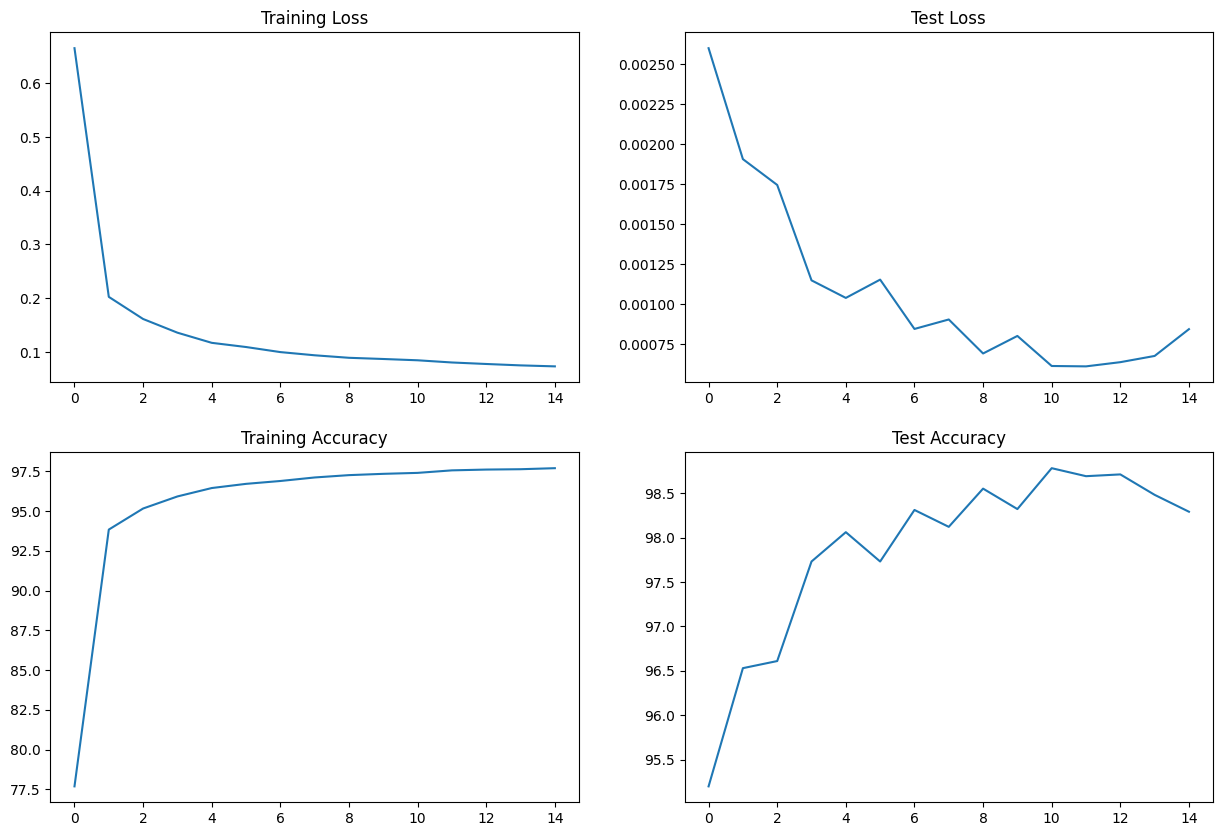

In [8]:
plot_acc_loss_S7()